In [3]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

CV_flag = False
DATAPATH = "data/digits.csv"
df = pd.read_csv(DATAPATH)
X = df.drop("label",axis=1).values
scaler = MinMaxScaler()
scaler.fit(X)
X_std = scaler.transform(X)
y = df["label"].values
labels = df["label"] 
X_train,X_test,y_train,y_test = train_test_split(X_std,y,test_size=0.2)
pipe = Pipeline([("scalar", MinMaxScaler()),("svm",svm.SVC(C= 1000, degree= 2, 
                                                           gamma = 0.001, kernel = 'poly'))])
pipe_grid = Pipeline([("scalar", MinMaxScaler()),("svm",svm.SVC())])    

C:\Users\ippei\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
E_list = np.zeros(784)
cumsum_explained = np.zeros(784)
for i in range(100,784):
    pca = PCA(n_components = i)  # 主成分分析オブジェクトの作成
    pca.fit(X_train)                       # 主成分分析の実行
    transformed = pca.transform(X_train)   # データに対して削減後のベクトルを生成
    E = pca.explained_variance_ratio_        # 寄与率
    cumsum_explained[i] = np.cumsum(E)[::-1][0]
    if cumsum_explained[i] > 0.95:
        break
    if i%10 == 0:
        print(i)
        print(cumsum_explained[i])
print(cumsum_explained[i])

100
0.9157450510401489
110
0.9246268750913108
120
0.9321356645347364
130
0.9385845752358093
140
0.9442397683181201
150
0.9492037053567488
0.9501120303233959


In [5]:
CV_flag=True
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
if CV_flag == True:
    parameters = [
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.001, 0.0001]},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['sigmoid'], 'svm__gamma': [0.001, 0.0001]}]
    clf = GridSearchCV(pipe_grid, param_grid=parameters,verbose=2,n_jobs=3)
    clf.fit(X_train_pca,y_train)
    print("Best cv accuracy:{:.2f}".format(clf.best_score_))
    print("Test set score: {:.2f}".format(clf.score(X_test_pca,y_test)))
    print("Best parameters:{}".format(clf.best_params_))
else:
    clf = pipe.fit(X_train,y_train)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 132 out of 132 | elapsed: 25.2min finished


Best cv accuracy:0.91
Test set score: 0.92
Best parameters:{'svm__C': 1, 'svm__kernel': 'linear'}


In [7]:
y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca,y_test))
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

0.9215
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       196
          1       0.99      0.96      0.98       225
          2       0.91      0.90      0.91       207
          3       0.91      0.92      0.92       203
          4       0.91      0.93      0.92       203
          5       0.90      0.88      0.89       188
          6       0.95      0.95      0.95       203
          7       0.95      0.90      0.92       205
          8       0.88      0.88      0.88       187
          9       0.88      0.93      0.90       183

avg / total       0.92      0.92      0.92      2000

[[187   0   1   0   0   2   3   0   3   0]
 [  0 217   2   2   0   0   0   0   3   1]
 [  3   0 187   1   3   2   1   2   6   2]
 [  4   0   5 187   0   3   0   1   3   0]
 [  1   0   1   0 188   0   1   1   0  11]
 [  2   0   1  10   1 166   2   1   3   2]
 [  2   0   0   0   4   4 193   0   0   0]
 [  1   0   6   0   5   1   0 184   2   6]
 [  0   3 

In [8]:
wrong_prediction = []
for counter,i in enumerate(y_test):
    if y_test[counter] == 8:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction.append(keep_list)
print(wrong_prediction)

[[94, 6], [231, 2], [331, 4], [340, 3], [401, 9], [431, 1], [627, 5], [666, 5], [667, 3], [761, 1], [808, 3], [853, 5], [1313, 6], [1342, 5], [1709, 9], [1724, 5], [1772, 1], [1847, 2], [1851, 2], [1870, 5], [1879, 3], [1880, 6], [1984, 5]]


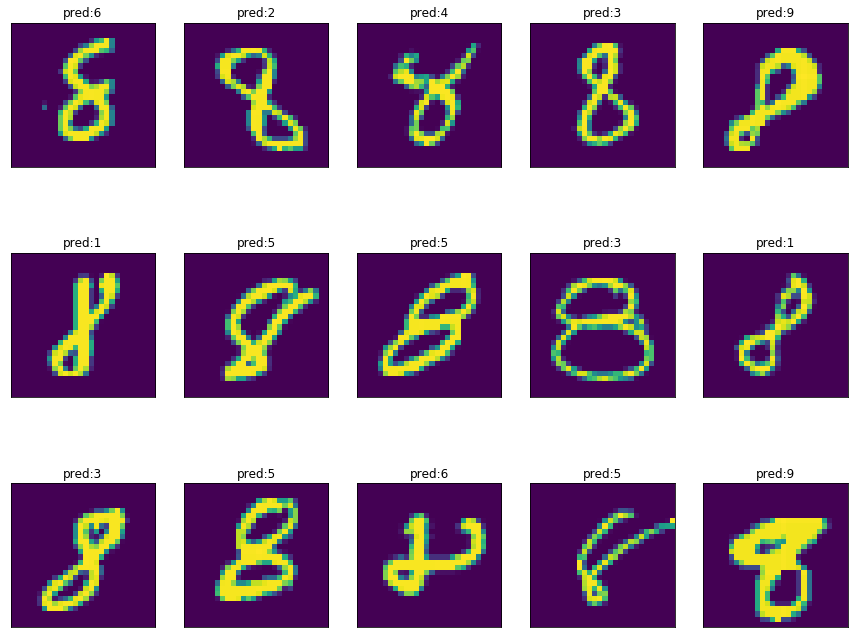

In [9]:
image_shape = [28,28]
fix, axes = plt.subplots(3,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction,axes.ravel()):
    ax.imshow(X_test[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))

In [10]:
"""
nmf = NMF(n_components=15,random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(3,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction_2,axes.ravel()):
    ax.imshow(X_test_nmf[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))
"""

'\nnmf = NMF(n_components=15,random_state=0)\nnmf.fit(X_train)\nX_train_nmf = nmf.transform(X_train)\nX_test_nmf = nmf.transform(X_test)\n\nfix, axes = plt.subplots(3,5,figsize=(15,12),\n                        subplot_kw={"xticks":(),"yticks":()})\nfor i,ax in zip(wrong_prediction_2,axes.ravel()):\n    ax.imshow(X_test_nmf[i[0]].reshape(image_shape))\n    ax.set_title("pred:{}".format(i[1]))\n'

In [11]:
if CV_flag == True:
    parameters = [
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.001, 0.0001]},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['sigmoid'], 'svm__gamma': [0.001, 0.0001]}]
    clf = GridSearchCV(pipe_grid, param_grid=parameters,verbose=2,n_jobs=3)
    clf.fit(X_train,y_train)
    print("Best cv accuracy:{:.2f}".format(clf.best_score_))
    print("Test set score: {:.2f}".format(clf.score(X_test,y_test)))
    print("Best parameters:{}".format(clf.best_params_))
else:
    clf = pipe.fit(X_train,y_train)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 10.6min
[Parallel(n_jobs=3)]: Done 132 out of 132 | elapsed: 77.9min finished


Best cv accuracy:0.95
Test set score: 0.96
Best parameters:{'svm__C': 1000, 'svm__degree': 2, 'svm__gamma': 0.001, 'svm__kernel': 'poly'}


In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import RFE
selecter_pipe = Pipeline([("scalar", MinMaxScaler()),
                         ("select",SelectFromModel(RFC(n_estimators=100,random_state=42),
                                                   threshold="median"))])
#selecter_pipe = Pipeline([("scalar", MinMaxScaler()),
#                         ("select",RFE(RFC(n_estimators=100,random_state=42),
#                                                   n_features_to_select=740,verbose=2))])

selecter_pipe.fit(X_train,y_train)

C:\Users\ippei\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Pipeline(memory=None,
     steps=[('scalar', MinMaxScaler(copy=True, feature_range=(0, 1))), ('select', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity...om_state=42, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold='median'))])

In [13]:
X_train_l1 = selecter_pipe.transform(X_train)
print(X_train.shape)
print(X_train_l1.shape)

(8000, 784)
(8000, 392)


In [14]:
X_test_l1 = selecter_pipe.transform(X_test)
clf_l1 = svm.SVC(C= 1000, degree= 2, 
                gamma = 0.001, kernel = 'poly').fit(X_train_l1,y_train)
score = clf_l1.score(X_test_l1,y_test)
print(score)

0.9565


In [15]:
y_pred = clf_l1.predict(X_test_l1)
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       196
          1       0.98      0.97      0.98       225
          2       0.93      0.94      0.93       207
          3       0.97      0.97      0.97       203
          4       0.94      0.97      0.95       203
          5       0.98      0.96      0.97       188
          6       0.96      1.00      0.98       203
          7       0.97      0.90      0.94       205
          8       0.96      0.94      0.95       187
          9       0.91      0.95      0.93       183

avg / total       0.96      0.96      0.96      2000

[[193   0   0   1   0   1   1   0   0   0]
 [  0 218   2   1   0   0   0   1   2   1]
 [  1   1 194   1   4   0   1   2   2   1]
 [  1   0   3 197   0   1   0   0   0   1]
 [  1   0   0   0 196   0   0   0   0   6]
 [  0   0   0   2   0 180   3   0   1   2]
 [  0   0   0   0   1   0 202   0   0   0]
 [  1   1   6   0   3   1   1 185   1   6]
 [  0   1   4   1

In [16]:
wrong_prediction_2_l1 = []
for counter,i in enumerate(y_test):
    if y_test[counter] == 2:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction_2_l1.append(keep_list)
print(wrong_prediction_2_l1)

[[166, 0], [302, 4], [343, 4], [747, 7], [975, 6], [1153, 3], [1284, 9], [1306, 7], [1354, 4], [1361, 8], [1621, 1], [1743, 8], [1915, 4]]
